<a href="https://colab.research.google.com/github/aureavaleria/DataBalancing-Research/blob/main/papers/Artigo%201/V5/Teste%203/vers%C3%A3o_5_(teste_03_rankeamento_de_atributos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd


# Carregar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/export.csv')
df.dropna(inplace=True)

# Definir as variáveis preditoras e a variável alvo
X = df[['Age recode with <1 year olds', 'Sex', 'Race recode (White, Black, Other)',
        'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Primary Site',
        'Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
        'CS tumor size (2004-2015)', 'CEA Pretreatment Interpretation Recode (2010+)',
        'Tumor Deposits Recode (2010+)', 'Marital status at diagnosis']]

y_liver = df['SEER Combined Mets at DX-liver (2010+)']
y_lung = df['SEER Combined Mets at DX-lung (2010+)']

y = pd.concat([y_liver, y_lung], axis=1)

In [ ]:
y = pd.concat([y_liver, y_lung], axis=1)

# Aplicar codificação a variáveis categóricas em 'X' usando LabelEncoder, para prepará-las para o modelo
for col in X.columns:
    if X[col].dtype == 'object':  # Verifica se a coluna é categórica (strings)
        X[col] = LabelEncoder().fit_transform(X[col])

# Função para combinar as informações de metástase hepática e pulmonar em uma coluna binária 'Binary Mets'
def combine_mets_binary(row):
    if row['SEER Combined Mets at DX-liver (2010+)'] == 'Yes' or row['SEER Combined Mets at DX-lung (2010+)'] == 'Yes':
        return 1  # Com metástase
    else:
        return 0  # Sem metástase

# Aplicar a função para criar a nova coluna binária 'Binary Mets' em 'y'
y['Binary Mets'] = y.apply(combine_mets_binary, axis=1)

# Verificar se 'X' e 'y' têm o mesmo número de amostras
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")

# Salvar o DataFrame 'y' em um arquivo CSV para referência futura ou análise adicional
y.to_csv('/content/Y.csv')

/tmp/ipython-input-106-2161679829.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
/tmp/ipython-input-106-2161679829.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
/tmp/ipython-input-106-2161679829.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Tamanho de X: 53448
Tamanho de y: 53448


## **Resumo e Ajuste do Pipeline ClinSMOTE + DBSCAN**
1. Seleção e Pré-processamento de Variáveis
Carregue os dados, trate valores ausentes e aplique label encoding nas variáveis categóricas.

**Padronize as variáveis contínuas se for usar DBSCAN (muito sensível à escala)**:

In [ ]:
# Padronização das variáveis contínuas
continuous_cols = ['Age recode with <1 year olds', 'CS tumor size (2004-2015)']
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

/tmp/ipython-input-107-2681680824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[continuous_cols] = scaler.fit_transform(X[continuous_cols])


2. **Seleção de Variáveis por Importância (RandomForest)**

Treine um RandomForest e extraia as importâncias das features:

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y['Binary Mets'])
importances = rf.feature_importances_
feat_importances = (
    pd.DataFrame({'feature': X.columns, 'importance': importances})
    .sort_values(by='importance', ascending=False)
    .reset_index(drop=True)
)
print(feat_importances.head(10))

                                          feature  importance
0                       CS tumor size (2004-2015)    0.155463
1                    Age recode with <1 year olds    0.121832
2                   Tumor Deposits Recode (2010+)    0.113763
3              Derived AJCC T, 7th ed (2010-2015)    0.103987
4                                    Primary Site    0.098256
5              Derived AJCC N, 7th ed (2010-2015)    0.098125
6  CEA Pretreatment Interpretation Recode (2010+)    0.080122
7                     Marital status at diagnosis    0.066155
8                        Grade Recode (thru 2017)    0.051063
9                         Histologic Type ICD-O-3    0.044790


In [ ]:
top_features = feat_importances['feature'].head(8).tolist()

**3. Agrupamento Clínico da Classe Minoritária com DBSCAN**

Filtre apenas as amostras da classe minoritária:

In [ ]:
minority_indices = y['Binary Mets'] == 1
X_minority = X.loc[minority_indices, top_features]

Execute o DBSCAN nessas variáveis:

In [ ]:
from sklearn.cluster import DBSCAN

# Ajuste eps e min_samples conforme necessário
dbscan = DBSCAN(eps=1, min_samples=3)
clusters = dbscan.fit_predict(X_minority)

# Adicione os rótulos de cluster
X_minority = X_minority.copy()
X_minority['cluster'] = clusters

**4. Geração de Amostras Sintéticas por ClinSMOTE (Interpolação)**

Para cada cluster diferente de -1 (ruído):

Identifique os vizinhos mais próximos.

Gere amostras sintéticas por interpolação das variáveis contínuas e sorteio das categóricas (se houver).

A quantidade de amostras sintéticas pode ser definida para igualar o número da classe majoritária ou atingir uma razão desejada.

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np

def clin_smote_generate(X_minority, X_train, n_samples=1):
    """
    Gera amostras sintéticas para cada cluster presente em X_minority.
    Retorna um DataFrame já pronto para juntar ao original,
    com todas as colunas de X_train (faltantes são preenchidas com média/moda).
    """
    synthetic_samples = []
    cols = X_minority.columns.drop('cluster')  # Colunas das features

    for cluster in X_minority['cluster'].unique():
        if cluster == -1:
            continue  # Pula o ruído
        group = X_minority[X_minority['cluster'] == cluster][cols]
        if len(group) < 2:
            continue  # Não gera para clusters muito pequenos
        neigh = NearestNeighbors(n_neighbors=2)
        neigh.fit(group)
        for i in range(n_samples * len(group)):
            idx = np.random.choice(group.index)
            sample = group.loc[[idx]]
            neighbor_idx = neigh.kneighbors(sample, return_distance=False)[0][1]
            neighbor = group.iloc[neighbor_idx].values.flatten()
            sample_values = sample.values.flatten()
            # Interpolação simples (para features contínuas)
            alpha = np.random.rand()
            new_sample = sample_values + alpha * (neighbor - sample_values)
            synthetic_samples.append(new_sample)

    synthetic_df = pd.DataFrame(synthetic_samples, columns=cols)

    # 4. Complete as colunas faltantes etc.
    for col in X_train.columns:
        if col not in synthetic_df.columns:
            if X_train[col].dtype in [np.float64, np.int64]:
                synthetic_df[col] = X_train[col].mean()
            else:
                synthetic_df[col] = X_train[col].mode()[0]
    synthetic_df = synthetic_df[X_train.columns]

    return synthetic_df


**5. Junção ao Conjunto Original**

Converta os sintéticos para DataFrame, atribua o mesmo nome de colunas, e adicione ao X original (também adicione os rótulos ao y):

In [ ]:
# Gera os sintéticos (DataFrame já pronto)
synthetic_df = synthetic_df = clin_smote_generate(X_minority, X_train, n_samples=1)
X_balanced = pd.concat([X, synthetic_df], ignore_index=True)
y_balanced = pd.concat([y['Binary Mets'], pd.Series([1]*len(synthetic_df))], ignore_index=True)


In [ ]:
# Definição dos modelos de aprendizado de máquina com hiperparâmetros ajustados
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=10,
        min_samples_split=2,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        bootstrap=True,
        criterion='entropy',
        max_depth=15,
        min_samples_leaf=5,
        min_samples_split=2,
        n_estimators=300,
        random_state=42
    ),
    "SVM": SVC(
        kernel='poly',
        gamma='scale',
        degree=3,
        C=10,
        probability=True,
        random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(
        leaf_size=20,
        metric='manhattan',
        n_neighbors=11,
        weights='uniform'
    ),
    "XGBoost": XGBClassifier(
        colsample_bytree=0.6,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        reg_alpha=0.1,
        reg_lambda=10.0,
        subsample=1.0,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_depth=3,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_leaf=5,
        min_samples_split=2,
        random_state=42
    )
}


clin_smote_generate(X_minority, X_train, n_samples=7)


smote_techniques = {
    "ClinSMOTE": clin_smote_generate
}

# Configuração da validação cruzada estratificada com 5 divisões (folds)
# Isso garante que a proporção de classes seja mantida em cada divisão, e o shuffle embaralha os dados antes de dividir
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Aplicando ClinSMOTE com Decision Tree

Aplicando ClinSMOTE com Random Forest

Aplicando ClinSMOTE com SVM

Aplicando ClinSMOTE com Naive Bayes

Aplicando ClinSMOTE com KNN

Aplicando ClinSMOTE com XGBoost

Aplicando ClinSMOTE com Gradient Boosting


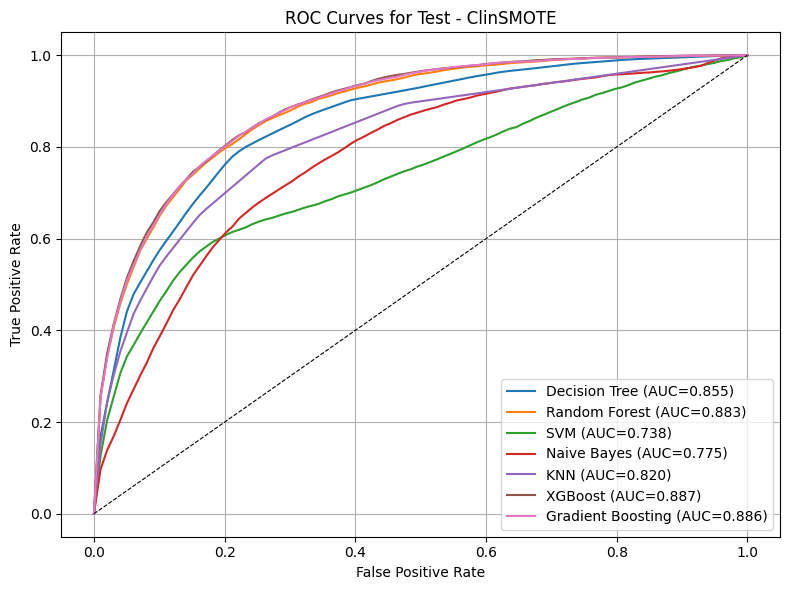

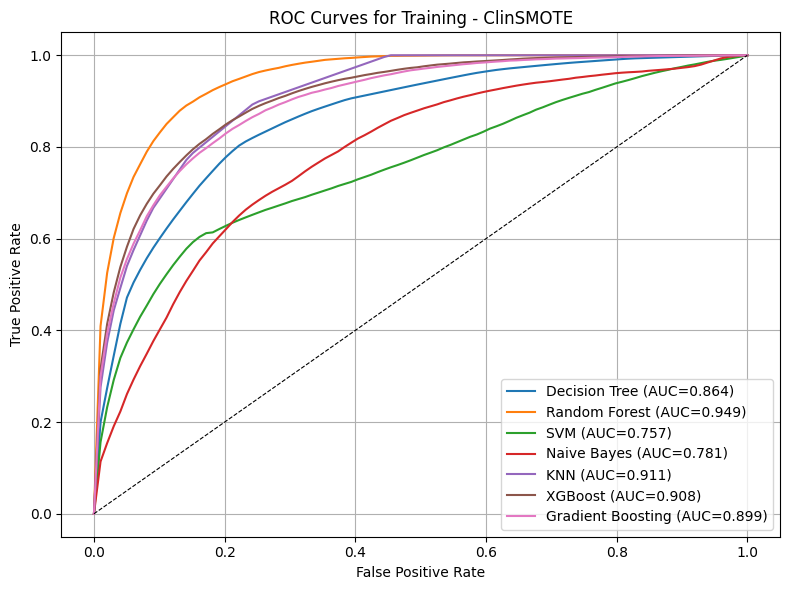


Tabela de Resultados - Teste:
  SMOTE Technique              Model  Accuracy       AUC  Precision  \
0       ClinSMOTE      Decision Tree  0.875150  0.855324   0.611693   
1       ClinSMOTE      Random Forest  0.885908  0.883047   0.713718   
2       ClinSMOTE                SVM  0.863119  0.737626   0.661409   
3       ClinSMOTE        Naive Bayes  0.824746  0.775394   0.402927   
4       ClinSMOTE                KNN  0.870528  0.819910   0.609771   
5       ClinSMOTE            XGBoost  0.887405  0.887215   0.696081   
6       ClinSMOTE  Gradient Boosting  0.886937  0.885799   0.688466   

   Recall rate  F1-score  
0     0.428027  0.503195  
1     0.382114  0.497613  
2     0.153301  0.248774  
3     0.381735  0.391885  
4     0.346571  0.441867  
5     0.424486  0.527160  
6     0.430558  0.529767  

Tabela de Resultados - Treinamento:
  SMOTE Technique              Model  Accuracy       AUC  Precision  \
0       ClinSMOTE      Decision Tree  0.874140  0.864427   0.648023   
1    

In [ ]:
        from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
        from sklearn.preprocessing import StandardScaler
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd

        # Dicionários para armazenar as curvas ROC para cada técnica e modelo, separando teste e treinamento
        roc_curves_test = {smote_name: {} for smote_name in smote_techniques.keys()}
        roc_curves_train = {smote_name: {} for smote_name in smote_techniques.keys()}

        # Listas para armazenar os resultados das tabelas para teste e treinamento
        results_table_test = []
        results_table_train = []

        # Iteração entre técnicas de balanceamento e modelos
        for smote_name, smote in smote_techniques.items():
            for model_name, model in models.items():
                print(f"\nAplicando {smote_name} com {model_name}")
                mean_fpr = np.linspace(0, 1, 100)

                # Listas para armazenar as curvas e métricas em cada fold (Teste)
                tprs_test = []
                aucs_test = []
                accuracies_test = []
                precisions_test = []
                recalls_test = []
                f1_scores_test = []

                # Listas para armazenar as curvas e métricas em cada fold (Treinamento)
                tprs_train = []
                aucs_train = []
                accuracies_train = []
                precisions_train = []
                recalls_train = []
                f1_scores_train = []

                # Validação cruzada
                for train_index, test_index in kf.split(X, y['Binary Mets']):
                    # Separando os dados
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y['Binary Mets'].iloc[train_index], y['Binary Mets'].iloc[test_index]

                    # Corrigir os índices antes de passar ao SMOTE
                    X_train = X_train.reset_index(drop=True)
                    y_train = pd.Series(y_train.reset_index(drop=True).values.ravel(), name='Binary Mets')

                    # Aplicar ClinSMOTE-SEER no conjunto de treinamento
                    if smote_name == "ClinSMOTE":
                        # 1. Filtra minoria
                        minority_indices = y_train == 1
                        X_train_minority = X_train.loc[minority_indices, :].copy()
                        # 2. Agrupa com DBSCAN
                        from sklearn.cluster import DBSCAN
                        clusters = DBSCAN(eps=1.0, min_samples=3).fit_predict(X_train_minority)
                        X_train_minority['cluster'] = clusters
                        # 3. Gera sintéticos
                        synthetic_df = clin_smote_generate(X_train_minority, X_train, n_samples=1)
                        # 4. Junta ao original
                        X_train_res = pd.concat([X_train, synthetic_df], ignore_index=True)
                        y_train_res = pd.concat([y_train, pd.Series([1]*len(synthetic_df))], ignore_index=True)
                    else:
                        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


                    # Normalizar os dados
                    scaler = StandardScaler()
                    X_train_res_scaled = scaler.fit_transform(X_train_res)
                    X_test_scaled = scaler.transform(X_test)

                    # Treinar o modelo com os dados balanceados
                    model.fit(X_train_res_scaled, y_train_res)

                    # ------------------------------
                    # Avaliação no conjunto de Teste
                    # ------------------------------
                    y_pred_test = model.predict(X_test_scaled)
                    y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

                    # Curva ROC para teste
                    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
                    interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
                    interp_tpr_test[0] = 0.0
                    tprs_test.append(interp_tpr_test)
                    aucs_test.append(auc(fpr_test, tpr_test))

                    # Métricas para teste
                    accuracies_test.append(accuracy_score(y_test, y_pred_test))
                    precisions_test.append(precision_score(y_test, y_pred_test))
                    recalls_test.append(recall_score(y_test, y_pred_test))
                    f1_scores_test.append(f1_score(y_test, y_pred_test))

                    # ------------------------------
                    # Avaliação no conjunto de Treinamento
                    # ------------------------------
                    y_pred_train = model.predict(X_train_res_scaled)
                    y_pred_proba_train = model.predict_proba(X_train_res_scaled)[:, 1]

                    # Curva ROC para treinamento
                    fpr_train, tpr_train, _ = roc_curve(y_train_res, y_pred_proba_train)
                    interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
                    interp_tpr_train[0] = 0.0
                    tprs_train.append(interp_tpr_train)
                    aucs_train.append(auc(fpr_train, tpr_train))

                    # Métricas para treinamento
                    accuracies_train.append(accuracy_score(y_train_res, y_pred_train))
                    precisions_train.append(precision_score(y_train_res, y_pred_train))
                    recalls_train.append(recall_score(y_train_res, y_pred_train))
                    f1_scores_train.append(f1_score(y_train_res, y_pred_train))

                # Cálculo das métricas médias para Teste
                mean_accuracy_test = np.mean(accuracies_test)
                mean_precision_test = np.mean(precisions_test)
                mean_recall_test = np.mean(recalls_test)
                mean_f1_test = np.mean(f1_scores_test)
                mean_auc_test = np.mean(aucs_test)

                # Cálculo das métricas médias para Treinamento
                mean_accuracy_train = np.mean(accuracies_train)
                mean_precision_train = np.mean(precisions_train)
                mean_recall_train = np.mean(recalls_train)
                mean_f1_train = np.mean(f1_scores_train)
                mean_auc_train = np.mean(aucs_train)

                # Armazenar as curvas ROC médias
                roc_curves_test[smote_name][model_name] = (mean_fpr, np.mean(tprs_test, axis=0), mean_auc_test)
                roc_curves_train[smote_name][model_name] = (mean_fpr, np.mean(tprs_train, axis=0), mean_auc_train)

                # Adicionar resultados à tabela de Teste
                results_table_test.append({
                    "SMOTE Technique": smote_name,
                    "Model": model_name,
                    "Accuracy": mean_accuracy_test,
                    "AUC": mean_auc_test,
                    "Precision": mean_precision_test,
                    "Recall rate": mean_recall_test,
                    "F1-score": mean_f1_test
                })

                # Adicionar resultados à tabela de Treinamento
                results_table_train.append({
                    "SMOTE Technique": smote_name,
                    "Model": model_name,
                    "Accuracy": mean_accuracy_train,
                    "AUC": mean_auc_train,
                    "Precision": mean_precision_train,
                    "Recall rate": mean_recall_train,
                    "F1-score": mean_f1_train
                })

        # ------------------------------
        # Plotar as curvas ROC para o conjunto de Teste
        # ------------------------------
        num_techniques = len(roc_curves_test)
        fig_test, axes_test = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
        if num_techniques == 1:
            axes_test = [axes_test]
        for i, technique in enumerate(roc_curves_test.keys()):
            ax = axes_test[i]
            for model_name, (fpr, tpr, mean_auc) in roc_curves_test[technique].items():
                ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
            ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
            ax.set_title(f"ROC Curves for Test - {technique}")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc='lower right')
            ax.grid()
        plt.tight_layout()
        plt.show()

        # ------------------------------
        # Plotar as curvas ROC para o conjunto de Treinamento
        # ------------------------------
        num_techniques = len(roc_curves_train)
        fig_train, axes_train = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
        if num_techniques == 1:
            axes_train = [axes_train]
        for i, technique in enumerate(roc_curves_train.keys()):
            ax = axes_train[i]
            for model_name, (fpr, tpr, mean_auc) in roc_curves_train[technique].items():
                ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
            ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
            ax.set_title(f"ROC Curves for Training - {technique}")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc='lower right')
            ax.grid()
        plt.tight_layout()
        plt.show()

        # ------------------------------
        # Criar e salvar as tabelas de resultados
        # ------------------------------
        results_df_test = pd.DataFrame(results_table_test)
        results_df_train = pd.DataFrame(results_table_train)

        results_df_test.to_csv("comparison_table_test.csv", index=False)
        results_df_train.to_csv("comparison_table_train.csv", index=False)

        print("\nTabela de Resultados - Teste:")
        print(results_df_test)
        print("\nTabela de Resultados - Treinamento:")
        print(results_df_train)
